In [1]:
import numpy as np
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
# optionally impose the Burke radius cut of 1.35 Rsun
doRadCut = False

Import the base DR25 catalog from the exoplanet archive

In [3]:
# download the DR25 stellar properties if it's not already in stellarCatalogs/
if False:
    urlstellar = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr25_stellar&select=*"

    r = requests.get(urlstellar)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    dr25Stellar = pd.read_csv(fh, dtype={"st_quarters":str})
    dr25Stellar.to_csv("stellarCatalogs/dr25_stellar_archive.txt", index=False)
else:
    dr25Stellar = pd.read_csv("stellarCatalogs/dr25_stellar_archive.txt", dtype={"st_quarters":str})

Import the DR25 supplemental catalog

In [4]:
# download the DR25 supplemental stellar properties if it's not already in stellarCatalogs/
if False:
    urlsupp = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr25_supp_stellar&select=*"
    r = requests.get(urlsupp)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    dr25StellarSup = pd.read_csv(fh, dtype={"st_quarters":str})
    dr25StellarSup.to_csv("stellarCatalogs/dr25_stellar_supp_archive.txt", index=False)
else:
    dr25StellarSup = pd.read_csv("stellarCatalogs/dr25_stellar_supp_archive.txt", dtype={"st_quarters":str})

Merge the two catalogs.  The supplemental catalog has fewer entries, so we have to be careful about the merge.  The merged catalog has the same number of entries as the supplemental catalog.

In [5]:
# merging with inner gives the intersection of kepids
mergedDr25Stellar = pd.merge(dr25Stellar, dr25StellarSup, on="kepid", how="inner")
# get the original column names
sColumns = list(dr25Stellar)

Because both catalogs share column names, mergedStellar has a column for each catalog, with the column names given an "\_x" for the stellar catalog and "\_y" for the supplemental.  We have to reconcile this by 
    a) restoring the original names, 
    b) copying the values in the supplemental catalog to the stellar columns for those columns specified in the supplemental documentation, and 
    c) removing the supplemental colums.

In [6]:
suppColNames = [ "kepid","teff","teff_err1","teff_err2","logg","logg_err1","logg_err2",
                "feh","feh_err1","feh_err2","radius","radius_err1","radius_err2",
                "mass","mass_err1","mass_err2","dens","dens_err1","dens_err2",
                "dist","dist_err1","dist_err2","av","av_err1","av_err2","prov_sec" ]

# first copy all the stellar paratmers to their original names
for i in range(1,len(sColumns)):
    mergedDr25Stellar[sColumns[i]] = mergedDr25Stellar[sColumns[i]+"_x"]
    
# now overwrite using the new columns (from Savita's erratum file)
for i in range(1,len(suppColNames)):
    mergedDr25Stellar[suppColNames[i]] = mergedDr25Stellar[suppColNames[i]+"_y"]

# drop the doubled columns
for i in range(1,len(sColumns)):
    mergedDr25Stellar = mergedDr25Stellar.drop([sColumns[i]+"_x", sColumns[i]+"_y"], axis=1)

print("the merged catalog has " + str(len(mergedDr25Stellar)) + " entries")



the merged catalog has 197096 entries


Save the merged catalog.

In [7]:
mergedDr25Stellar.to_csv("stellarCatalogs/dr25_stellar_updated_feh.txt", index=False)

Now restore the entries in the original stellar catalog that are not in the supplemental catalog.  First we identify the original-only entries by repeating the merge, then entries in the merge from the stellar table.  Then we concat the remaining entries with the merged table.  Finally we save the final full table.

In [8]:
# now get the stars not in the stellar_supp by dropping stars in the merge from stellar (using reset index)
merge2 = pd.merge(dr25Stellar.reset_index(), dr25StellarSup, on="kepid", how="inner")
dr25StellarNoSup = dr25Stellar.drop(merge2["index"])

# now concat the merged set and the non-supp stars
dr25StellarFullMerged = pd.concat([mergedDr25Stellar, dr25StellarNoSup])

# print(list(stellar_full_merged))
print("the final catalog has " + str(len(dr25StellarFullMerged)) + " entries")

dr25StellarFullMerged.to_csv("stellarCatalogs/dr25_stellar_updated_feh_all.txt", index=False)

the final catalog has 200038 entries


Next we bring in the Gaia-derived properties from Berger et. al. (http://adsabs.harvard.edu/abs/2018ApJ...866...99B).  This provides improved radii and distances.  It also includes effective temperatures that differ from the DR25 catalog, but we believe the DR25 catalog's effectiv temperatures are more reliable. The Berger table has 177,911 entries, and we will restrict our analysis to the stellar population in the Berger table.

In [9]:
from astropy.io import ascii

# read the publised table from Berger et. al. 
gaiaUpdates = ascii.read("stellarCatalogs/apj_table1_published.txt")

gaiaUpdatesPd = gaiaUpdates.to_pandas();
dr25GaiaStellar = pd.merge(dr25StellarFullMerged, gaiaUpdatesPd, left_on="kepid", right_on="KIC", how="inner")

# copy the dr25 distance and radius to renamed columns in case anyone wants to compare
dr25GaiaStellar["dist_DR25"] = dr25GaiaStellar["dist"]
dr25GaiaStellar["dist_DR25_err1"] = dr25GaiaStellar["dist_err1"]
dr25GaiaStellar["dist_DR25_err2"] = dr25GaiaStellar["dist_err2"]

dr25GaiaStellar["radius_DR25"] = dr25GaiaStellar["radius"]
dr25GaiaStellar["radius_DR25_err1"] = dr25GaiaStellar["radius_err1"]
dr25GaiaStellar["radius_DR25_err2"] = dr25GaiaStellar["radius_err2"]

# copy Gaia distance to the dr25 distance column
dr25GaiaStellar["dist"] = dr25GaiaStellar["D"]
# for DR25, err1 is the upper uncertainty, err2 is the lower uncertainty and is < 0
# for Gaia, E_D is the upper uncertainty, E_d is the lower uncertainty and is > 0
dr25GaiaStellar["dist_err1"] = dr25GaiaStellar["E_D"]
dr25GaiaStellar["dist_err2"] = -dr25GaiaStellar["e_D"]
# copy Gaia radius to the dr25 radius column
dr25GaiaStellar["radius"] = dr25GaiaStellar["R*"]
# for DR25, err1 is the upper uncertainty, err2 is the lower uncertainty and is < 0
# for Gaia, E_R* is the upper uncertainty, E_R* is the lower uncertainty and is > 0
dr25GaiaStellar["radius_err1"] = dr25GaiaStellar["E_R*"]
dr25GaiaStellar["radius_err2"] = -dr25GaiaStellar["e_R*"]

# we'll leave the Gaia columns in place because they have different names
print("the gaia/Berger catalog has " + str(len(dr25GaiaStellar)) + " entries")

dr25GaiaStellar.to_csv("stellarCatalogs/dr25_stellar_supp_gaia.txt", index=False)

the gaia/Berger catalog has 177911 entries


dr25_stellar_supp_gaia.txt is our base catalog.  We now apply several cuts to restrict our occurrence rate analysis to targets for which we have reliable completeness information, following the guidelines in Section 3.6 of https://exoplanetarchive.ipac.caltech.edu/docs/KSCI-19111-002.pdf.

In [10]:
cleanDr25GaiaStellar = dr25GaiaStellar

First we remove the stars marked binary due to Gaia radius (Bin = 1 or 3) or evolved (Evol > 0).  We do not remove targets with AO companions (Bin = 2) because the target star population was not uniformly surveyed with AO.  We expect few evolved stars because most should have been removed by the R <= 1.25 cut.



In [11]:
binaryDr25GaiaStellar = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.Bin == 1)|(cleanDr25GaiaStellar.Bin == 3)]
print("There are " + str(len(binaryDr25GaiaStellar)) + " targets with binary flag == 1 or 3")

evolvedDr25GaiaStellar = cleanDr25GaiaStellar[cleanDr25GaiaStellar.Evol > 0]
print("There are " + str(len(evolvedDr25GaiaStellar)) + " targets with evolved flag > 0")

cleanDr25GaiaStellar = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.Bin == 0)|(cleanDr25GaiaStellar.Bin == 2)]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing marked binaries")
cleanDr25GaiaStellar = cleanDr25GaiaStellar[cleanDr25GaiaStellar.Evol == 0]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing marked evolved stars")

There are 3142 targets with binary flag == 1 or 3
There are 58132 targets with evolved flag > 0
174769 entries after removing marked binaries
116637 entries after removing marked evolved stars


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


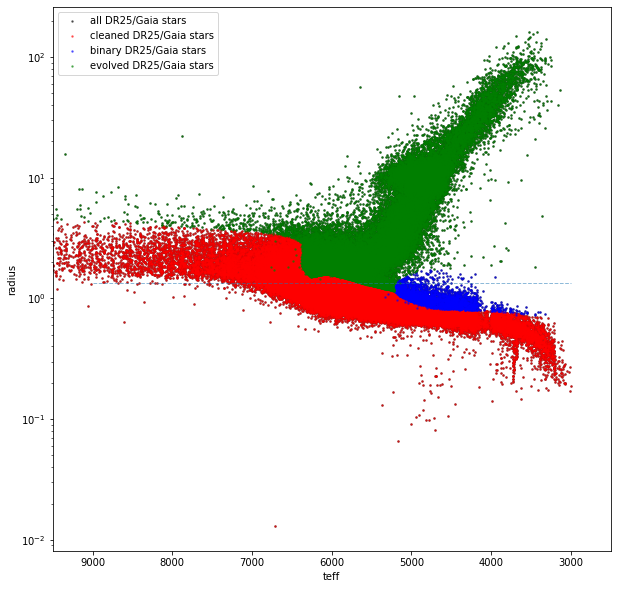

In [12]:
plt.figure(figsize=(10,10))
plt.semilogy(dr25GaiaStellar.teff, dr25GaiaStellar["R*"], ".k", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellar.teff, cleanDr25GaiaStellar["R*"], ".r", ms=3, alpha=0.5)
plt.semilogy(binaryDr25GaiaStellar.teff, binaryDr25GaiaStellar["R*"], ".b", ms=3, alpha=0.5)
plt.semilogy(evolvedDr25GaiaStellar.teff, evolvedDr25GaiaStellar["R*"], ".g", ms=3, alpha=0.5)
plt.semilogy([9000,3000], [1.35,1.35], linestyle='--', linewidth=1, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all DR25/Gaia stars", "cleaned DR25/Gaia stars", "binary DR25/Gaia stars", "evolved DR25/Gaia stars"))
plt.ylabel("radius")
plt.xlabel("teff")
plt.show()

Next we remove stars that are on the list https://github.com/nasa/KeplerPORTs/blob/master/DR25_DEModel_NoisyTargetList.txt.

In [13]:
noisyTargets = pd.read_csv("data/DR25_DEModel_NoisyTargetList.txt", header=9)
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~dr25GaiaStellar.kepid.isin(noisyTargets['# 1- Kepler ID'])]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing noisy targets")

114915 entries after removing noisy targets


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Next we remove stars with radii > 1.35 Rsun (to match what Chris is currently doing - the KSCI recommends 1.25 Rsun).

In [14]:
if doRadCut:
    cleanDr25GaiaStellar = cleanDr25GaiaStellar[dr25GaiaStellar.radius <= 1.35]
    print(str(len(cleanDr25GaiaStellar)) + " entries after removing R > 1.35 targets")

Next we remove stars with nan limb darkening coefficients.

In [15]:
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~np.isnan(dr25GaiaStellar.limbdark_coeff1)]
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~np.isnan(dr25GaiaStellar.limbdark_coeff2)]
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~np.isnan(dr25GaiaStellar.limbdark_coeff3)]
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~np.isnan(dr25GaiaStellar.limbdark_coeff4)]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing Nan limb darkening targets")

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


114403 entries after removing Nan limb darkening targets


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Next we remove stars with duty cycle = nan.

In [16]:
cleanDr25GaiaStellar = cleanDr25GaiaStellar[~np.isnan(dr25GaiaStellar.dutycycle)]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing Nan dutycycle targets")

114403 entries after removing Nan dutycycle targets


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Next we remove stars that have had a drop in duty cycle > 30% due to the removal of transits. (10% in KSCI)

In [17]:
dutyCycleChange = cleanDr25GaiaStellar.dutycycle - cleanDr25GaiaStellar.dutycycle_post
cleanDr25GaiaStellar = cleanDr25GaiaStellar[dutyCycleChange/cleanDr25GaiaStellar.dutycycle <= 0.3]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing duty cycle drops > 0.3")

109857 entries after removing duty cycle drops > 0.3


Next we remove stars that have duty cycles < 0.6.

In [18]:
cleanDr25GaiaStellar = cleanDr25GaiaStellar[cleanDr25GaiaStellar.dutycycle >= 0.6]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing after removing stars with duty cycle < 0.6")

106234 entries after removing after removing stars with duty cycle < 0.6


Next we remove stars with data span < 1000

In [19]:
cleanDr25GaiaStellar = cleanDr25GaiaStellar[cleanDr25GaiaStellar.dataspan >= 1000]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing after removing stars with data span < 1000")

97357 entries after removing after removing stars with data span < 1000


Next we remove stars with the timeoutsumry flag != 1.

In [20]:
cleanDr25GaiaStellar = cleanDr25GaiaStellar[cleanDr25GaiaStellar.timeoutsumry == 1]
print(str(len(cleanDr25GaiaStellar)) + " entries after removing after removing stars with timeoutsumry != 1")

91224 entries after removing after removing stars with timeoutsumry != 1


In [21]:
catalogHeader = "dr25_stellar_supp_gaia_clean"
if doRadCut:
    catalogHeader = catalogHeader + "_radCut"

cleanDr25GaiaStellar.to_csv("stellarCatalogs/" + catalogHeader + "_all.txt", index=False)

This produces the clean master list dr25_stellar_supp_gaia_clean.txt from which we will extract specific spectral types.

We extract desired spectral types using the teff boundaries from Pecaut and Mamajek 2013 http://iopscience.iop.org/article/10.1088/0067-0049/208/1/9/meta;jsessionid=698F3A9F5272B070DC62876C1764BFDB.c1#apjs480616s3: <br>
M: 2400 <= T < 3900  <br>
K: 3900 <= T < 5300<br>
G: 5300 <= T < 6000<br>
F: 6000 <= T < 7300<br>


In [22]:
cleanDr25GaiaStellarG = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.teff >= 5300)&(cleanDr25GaiaStellar.teff < 6000)]
print(str(len(cleanDr25GaiaStellarG)) + " G targets")

cleanDr25GaiaStellarK = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.teff >= 3900)&(cleanDr25GaiaStellar.teff < 5300)]
print(str(len(cleanDr25GaiaStellarK)) + " K targets")

cleanDr25GaiaStellarM = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.teff >= 2400)&(cleanDr25GaiaStellar.teff < 3900)]
print(str(len(cleanDr25GaiaStellarM)) + " M targets")

cleanDr25GaiaStellarGK = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.teff >= 3900)&(cleanDr25GaiaStellar.teff < 6000)]
print(str(len(cleanDr25GaiaStellarGK)) + " GK targets")

cleanDr25GaiaStellarGKM = cleanDr25GaiaStellar[(cleanDr25GaiaStellar.teff >= 2400)&(cleanDr25GaiaStellar.teff < 6000)]
print(str(len(cleanDr25GaiaStellarGKM)) + " GKM targets")

# always save the GK catalog
cleanDr25GaiaStellarGK.to_csv("stellarCatalogs/" + catalogHeader + "_GK.txt", index=False)

# only save the other catalogs if we're not doing the radius cut variation
if doRadCut == False:
    cleanDr25GaiaStellarG.to_csv("stellarCatalogs/" + catalogHeader + "_G.txt", index=False)
    cleanDr25GaiaStellarK.to_csv("stellarCatalogs/" + catalogHeader + "_K.txt", index=False)
    cleanDr25GaiaStellarM.to_csv("stellarCatalogs/" + catalogHeader + "_M.txt", index=False)
    cleanDr25GaiaStellarGKM.to_csv("stellarCatalogs/" + catalogHeader + "_GKM.txt", index=False)

37065 G targets
16107 K targets
1545 M targets
53172 GK targets
54717 GKM targets


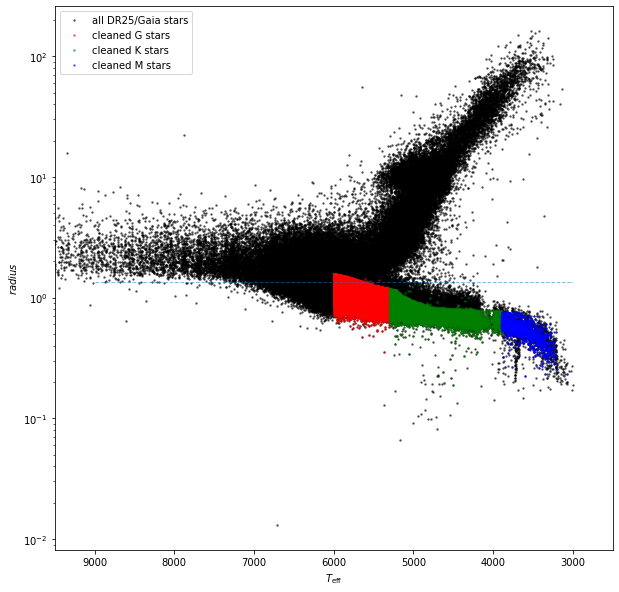

In [23]:
plt.figure(figsize=(10,10))
plt.semilogy(dr25GaiaStellar.teff, dr25GaiaStellar["R*"], ".k", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarG.teff, cleanDr25GaiaStellarG["R*"], ".r", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarK.teff, cleanDr25GaiaStellarK["R*"], ".g", ms=3, alpha=0.5)
plt.semilogy(cleanDr25GaiaStellarM.teff, cleanDr25GaiaStellarM["R*"], ".b", ms=3, alpha=0.5)
plt.semilogy([9000,3000], [1.35,1.35], linestyle='--', linewidth=1, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all DR25/Gaia stars", "cleaned G stars", "cleaned K stars", "cleaned M stars"))
plt.ylabel("$radius$")
plt.xlabel("$T_\mathrm{eff}$")
plt.show()

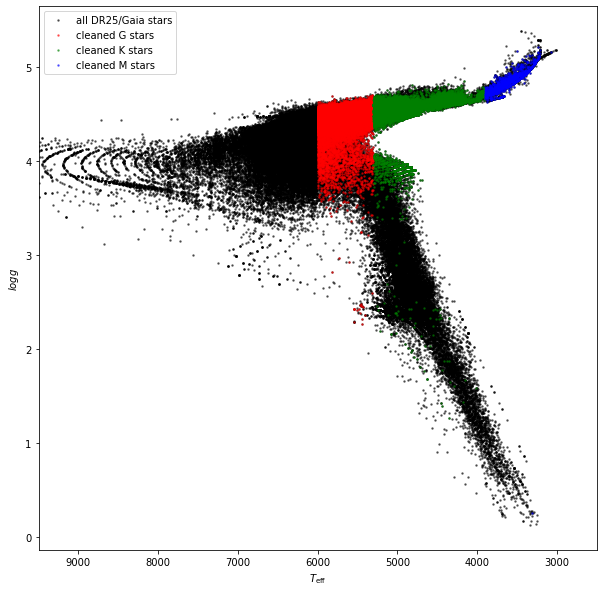

In [24]:
plt.figure(figsize=(10,10))
plt.plot(dr25GaiaStellar.teff, dr25GaiaStellar.logg, ".k", ms=3, alpha=0.5)
plt.plot(cleanDr25GaiaStellarG.teff, cleanDr25GaiaStellarG.logg, ".r", ms=3, alpha=0.5)
plt.plot(cleanDr25GaiaStellarK.teff, cleanDr25GaiaStellarK.logg, ".g", ms=3, alpha=0.5)
plt.plot(cleanDr25GaiaStellarM.teff, cleanDr25GaiaStellarM.logg, ".b", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.legend(("all DR25/Gaia stars", "cleaned G stars", "cleaned K stars", "cleaned M stars"))
plt.ylabel("$logg$")
plt.xlabel("$T_\mathrm{eff}$")
plt.show()

In [25]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [26]:
%%bash -s 
jupyter nbconvert --to html createStellarCatalogs.ipynb
mv createStellarCatalogs.html createStellarCatalogs.html

[NbConvertApp] Converting notebook createStellarCatalogs.ipynb to html
[NbConvertApp] Writing 754143 bytes to createStellarCatalogs.html
